In [1]:
from typing import TypedDict, Optional, List

class AgentState(TypedDict):
    """그래프 상태를 나타내는 클래스."""
    url: str
    query: str
    selector: Optional[str]
    content: Optional[str]
    extracted_elements: Optional[List[str]]

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
load_dotenv()

def generate_selector(state: AgentState):
    """자연어 쿼리를 기반으로 CSS 셀렉터를 생성하는 함수."""
    print("CSS 셀렉터 생성 중...")
    
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         """당신은 사용자의 요청을 분석하여 웹페이지에서 특정 HTML 요소를 찾는 데 가장 적합한 CSS 셀렉터를 반환하는 전문가입니다.
         
         다음 규칙을 반드시 지켜야 합니다:
         1. **CSS 셀렉터 문자열만 반환해야 합니다.**
         2. **만약 사용자의 쿼리에 해당하는 적절한 CSS 셀렉터를 찾을 수 없다면, 'None'이라는 문자열을 반환해야 합니다.**
         3. **HTML 요소의 본문을 의미하는 'body'는 특별한 경우를 제외하고는 반환하지 않습니다. (예: 사용자가 명확하게 'body'를 찾으라고 요청한 경우)**
         
         예시:
         쿼리: "블로그 제목들을 찾아줘"
         반환: "h2.f-display-2.relative"
         
         쿼리: "모든 이미지의 URL을 찾아줘"
         반환: "img"
         
         쿼리: "특정 클래스가 포함된 문단들을 찾아줘"
         반환: "p.some-class"
         
         쿼리: "페이지에 존재하지 않는 엉뚱한 요소를 찾아줘"
         반환: "None"
         
         쿼리: "웹페이지의 본문을 찾아줘"
         반환: "body"
         
         반드시 규칙에 따라 CSS 셀렉터 문자열 또는 'None'만 반환해야 합니다."""),
        ("user", "웹페이지 HTML:\n\n{html_content}\n\n사용자 쿼리:\n\n{query}")
    ])
    
    chain = prompt | model
    
    try:
        result = chain.invoke({"html_content": state["content"], "query": state["query"]})
        
        # LLM의 응답을 확인하고 None을 반환하도록 로직 추가
        if result.content.strip() == "None":
            state["selector"] = None
            state["extracted_elements"] = None # 실패 시 extracted_elements 키를 None으로 명시적 추가
        else:
            state["selector"] = result.content
        
        print(f"생성된 셀렉터: {state['selector']}")
    except Exception as e:
        print(f"CSS 셀렉터 생성 오류: {e}")
        state["selector"] = None
        state["extracted_elements"] = None # 예외 발생 시 extracted_elements 키를 None으로 명시적 추가
        
    return state

In [3]:
import requests

# 웹페이지 로딩 노드
def fetch_webpage_content(state: AgentState):
    """URL에서 웹페이지 콘텐츠를 가져오는 함수."""
    print("웹페이지 콘텐츠 로딩 중...")
    url = state["url"]
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        state["content"] = response.text
    except requests.exceptions.RequestException as e:
        print(f"웹페이지 로딩 오류: {e}")
        state["content"] = None
    return state

In [4]:
from bs4 import BeautifulSoup

def extract_html_elements(state: AgentState):
    """웹페이지 콘텐츠에서 특정 HTML 요소를 추출하고 outerHTML을 반환하는 함수."""
    print("HTML 요소 추출 중...")
    if not state["content"]:
        state["extracted_elements"] = None
        return state

    try:
        soup = BeautifulSoup(state["content"], 'html.parser')
        elements = soup.select(state["selector"])
        
        extracted_html_list = []
        for element in elements:
            extracted_html_list.append(element.prettify())
            
        state["extracted_elements"] = extracted_html_list
    except Exception as e:
        print(f"HTML 요소 추출 오류: {e}")
        state["extracted_elements"] = None

    return state

In [5]:
def generate_output(state: AgentState):
    """분석 결과를 최종 출력하는 함수."""
    print("결과 생성 중...")
    
    # .get() 메서드를 사용하여 키가 없을 때 None을 반환하도록 수정
    extracted_elements = state.get("extracted_elements")
    
    if extracted_elements:
        print("\n--- 추출된 HTML 요소 텍스트 ---")
        for i, text in enumerate(extracted_elements):
            print(f"{i+1}. {text[:100]}...")  # 긴 텍스트는 일부만 출력
    else:
        print("\n--- 추출 실패 ---")
        print("요소를 찾을 수 없거나 오류가 발생했습니다.")
        
    return state

In [6]:
from langgraph.graph import StateGraph, END

# 그래프 생성
graph_builder = StateGraph(AgentState)

# 노드 추가
graph_builder.add_node("fetch_content", fetch_webpage_content)
graph_builder.add_node("generate_selector", generate_selector)
graph_builder.add_node("extract_html_elements", extract_html_elements)
graph_builder.add_node("generate_output", generate_output)

# 엣지 연결
graph_builder.set_entry_point("fetch_content")
graph_builder.add_edge("fetch_content", "generate_selector")
graph_builder.add_edge("generate_selector", "extract_html_elements")
graph_builder.add_edge("extract_html_elements", "generate_output")
graph_builder.add_edge("generate_output", END)

# 그래프 컴파일
graph = graph_builder.compile()

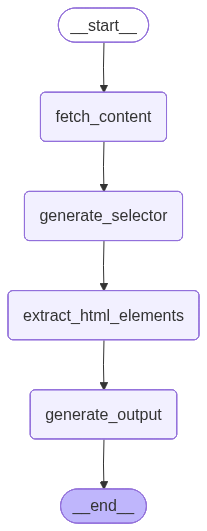

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
url="https://www.anthropic.com/engineering/building-effective-agents"
query="제목을 찾아줘"

In [9]:
# 그래프 실행
inputs = {
    "url": url,
    "query": query
}

result = graph.invoke(inputs)

print("\nLangGraph 실행 완료.")

웹페이지 콘텐츠 로딩 중...
CSS 셀렉터 생성 중...
생성된 셀렉터: h1.display-sans-xl.bold
HTML 요소 추출 중...
결과 생성 중...

--- 추출된 HTML 요소 텍스트 ---
1. <h1 class="display-sans-xl bold">
 Building effective agents
</h1>
...

LangGraph 실행 완료.


In [10]:
url="https://www.anthropic.com/engineering/building-effective-agents"
query = "빌보드 차트 1위 곡은?"

In [11]:
# 그래프 실행
inputs = {
    "url": url,
    "query": query
}

result = graph.invoke(inputs)

print("\nLangGraph 실행 완료.")

웹페이지 콘텐츠 로딩 중...
CSS 셀렉터 생성 중...
생성된 셀렉터: None
HTML 요소 추출 중...
HTML 요소 추출 오류: 'NoneType' object has no attribute 'replace'
결과 생성 중...

--- 추출 실패 ---
요소를 찾을 수 없거나 오류가 발생했습니다.

LangGraph 실행 완료.
